In [1]:
from ue.uexp.dataprocessing.processor_binance import BinanceProcessor
from ue.uexp.dataprocessing.func import *
from ue.uexp.dataprocessing.ta import *
from ue.uexp.models.util import *

#======TA==============
from ta.momentum import *
from ta.trend import *
from ta.volatility import *
from ta.wrapper import *
import ta
#=========================
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (20, 10)

import warnings
warnings.filterwarnings('ignore')

# Introduction

We use MLP, multiple variables ([log_ret_0, ..., log_ret_29, volume, spread, log_price_change, ...] to predict -> log_return")

## Predicting on
- log_return of price at next timestep

## Data + preprocessing

In [2]:
### get data (set config params)
ticker_list = ["BTCUSDT"]
start_date = "2021-12-30"
end_date = "2021-12-31"
time_interval = "1s"

p = BinanceProcessor("binance")
df = p.download_data(ticker_list, start_date, end_date, time_interval)

Found 1 symbols
[1/1] - start download daily BTCUSDT aggTrades 

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-29.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-30.csv

file already exists! ./cache/tick_raw/BTCUSDT-aggTrades-2021-12-31.csv


In [3]:
df.drop(["tic"], axis=1, inplace=True)
df.columns = ["Open","High","Low","Close","Volume"]

In [4]:
df.head()

,Open,High,Low,Close,Volume
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262


## Adding TAs

#### Volatility Indicators

In [5]:
# #bbs: EITHER 0 or 1. Very bad
# # Add bollinger band high indicator filling nans values
# df["bb_high_indicator"] = ta.volatility.bollinger_hband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )
# # Add bollinger band low indicator filling nans values
# df["bb_low_indicator"] = ta.volatility.bollinger_lband_indicator(
#     df["Close"], window=120, window_dev=10, fillna=True
# )

In [6]:
#df.head(50)

#### Momentum Indicators
- Rate of change (ROC)
- Relative Strenght Index (RSI)
- Stochastic RSI (sRSI, srsi_k, srsi_d)
- True Strength Index (TSI)

In [7]:
window = 30 # a choice
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()
df[f"roc_{window}"] = ta.momentum.ROCIndicator(close=df["Close"], window=window).roc()

# Relative Strength Index (RSI)
df["momentum_rsi"] = RSIIndicator(
    close=df["Close"], window=14, fillna=True
).rsi()/100 #scale 0-1

# Stoch RSI (StochRSI)
indicator_srsi = StochRSIIndicator(
    close=df["Close"], window=14, smooth1=3, smooth2=3, fillna=True
)
df["momentum_stoch_rsi"] = indicator_srsi.stochrsi()
df["momentum_stoch_rsi_k"] = indicator_srsi.stochrsi_k()
df["momentum_stoch_rsi_d"] = indicator_srsi.stochrsi_d()

# TSI Indicator
df["momentum_tsi"] = TSIIndicator(
    close=df["Close"], window_slow=25, window_fast=13, fillna=True
).tsi()/100 #scale 0-1

In [8]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629


#### Volume indicators
- Money Flow Index (MFI)
- Chaikin Money Flow (CMF)
- Force Index (FI)
- Volume Weighted Average Price (VWAP)
- ~Accumulation/Distribution Index (ADI)~
- ~On-Balance Volume (OBV)~
- ~Ease of Movement (EoM, EMV)~
- ~Volume-price Trend (VPT)~
- ~Negative Volume Index (NVI)~

In [9]:
# Chaikin Money Flow
df["volume_cmf"] = ChaikinMoneyFlowIndicator(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
).chaikin_money_flow()

# Money Flow Index
df["volume_mfi"] = MFIIndicator(
            high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True
        ).money_flow_index()/100 #norm to 0-1

# Force Index
df["volume_fi"] = ForceIndexIndicator(
    close=df["Close"], volume=df["Volume"], window=13, fillna=True
).force_index()

# Volume Weighted Average Price
df["volume_vwap"] = VolumeWeightedAveragePrice(
    high=df["High"], low=df["Low"], close=df["Close"], volume=df["Volume"], fillna=True,
    window=14,
).volume_weighted_average_price()

In [10]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.500000,0.000000,46466.703333
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,-16.745680,46465.557715
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,-15.609408,46464.265572
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,-13.379492,46464.226297
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,-11.468854,46463.629546
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,0.031384,-9.830145,46463.404020
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,0.031012,-8.425954,46463.321194
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,0.031012,-7.222246,46462.959543
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,0.043367,-6.190371,46462.879979
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,0.043200,-5.306070,46462.856239


#### Trend indicators
- Simple Moving Average (SMA) (slow only)
- Exponential Moving Average (EMA) (slow only)
- Moving Average Convergence Divergence (MACD, signal, diff)

In [11]:
# MACD
indicator_macd = MACD(
    close=df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True
)
df["trend_macd"] = indicator_macd.macd()
df["trend_macd_signal"] = indicator_macd.macd_signal()
df["trend_macd_diff"] = indicator_macd.macd_diff()

# SMAs
# df["trend_sma_fast"] = SMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).sma_indicator()
df["trend_sma_slow"] = SMAIndicator(
    close=df["Close"], window=26, fillna=True
).sma_indicator()

# EMAs
# df["trend_ema_fast"] = EMAIndicator(
#     close=df["Close"], window=12, fillna=True
# ).ema_indicator()
df["trend_ema_slow"] = EMAIndicator(
    close=df["Close"], window=26, fillna=True
).ema_indicator()

In [12]:
df.head(50)

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.500000,0.000000,46466.703333,0.000000,0.000000,0.000000,46467.730000,46467.730000
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,-16.745680,46465.557715,-0.271225,-0.054245,-0.216980,46466.030000,46467.478148
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,-15.609408,46464.265572,-1.142741,-0.271944,-0.870797,46462.696667,46466.630137
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,-13.379492,46464.226297,-1.812529,-0.580061,-1.232468,46461.030000,46465.844942
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,-11.468854,46463.629546,-2.317435,-0.927536,-1.389899,46460.028000,46465.117168
2021-12-30 00:00:05,46456.03,46456.03,46456.02,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,0.031384,-9.830145,46463.404020,-2.685809,-1.279190,-1.406618,46459.361667,46464.444045
2021-12-30 00:00:06,46456.02,46456.03,46456.02,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,0.031012,-8.425954,46463.321194,-2.944611,-1.612275,-1.332336,46458.884286,46463.820041
2021-12-30 00:00:07,46456.03,46456.03,46456.02,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,0.031012,-7.222246,46462.959543,-3.113819,-1.912584,-1.201236,46458.526250,46463.242261
2021-12-30 00:00:08,46456.02,46456.03,46456.02,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,0.043367,-6.190371,46462.879979,-3.210107,-2.172088,-1.038019,46458.248889,46462.708019
2021-12-30 00:00:09,46456.03,46456.03,46456.02,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,0.043200,-5.306070,46462.856239,-3.249762,-2.387623,-0.862139,46458.026000,46462.212610


### use gen_feats0

In [13]:
df = gen_feats0(df)
df

,Open,High,Low,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,...,volume_vwap,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade
2021-12-30 00:00:00,46464.66,46467.73,46464.65,46467.73,0.39143,NaN,1.000000,0.000000,0.000000,0.000000,...,46466.703333,0.000000,0.000000,0.000000,46467.730000,46467.730000,3.08,0.00,0.01,3.07
2021-12-30 00:00:01,46467.73,46471.83,46460.24,46464.33,4.92520,NaN,0.000000,0.000000,0.000000,0.000000,...,46465.557715,-0.271225,-0.054245,-0.216980,46466.030000,46467.478148,11.59,4.10,4.09,-3.40
2021-12-30 00:00:02,46461.29,46461.29,46456.02,46456.03,1.05925,NaN,0.000000,0.000000,0.000000,0.000000,...,46464.265572,-1.142741,-0.271944,-0.870797,46462.696667,46466.630137,5.27,0.00,0.01,-5.26
2021-12-30 00:00:03,46456.02,46456.03,46456.02,46456.03,0.03054,NaN,0.000000,0.000000,0.000000,0.000000,...,46464.226297,-1.812529,-0.580061,-1.232468,46461.030000,46465.844942,0.01,0.00,0.00,0.01
2021-12-30 00:00:04,46456.02,46456.03,46456.02,46456.02,0.50262,NaN,0.000000,0.000000,0.000000,0.000000,...,46463.629546,-2.317435,-0.927536,-1.389899,46460.028000,46465.117168,0.01,0.01,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:59:55,46216.94,46216.94,46216.93,46216.94,0.01090,-0.014235,0.338271,0.001432,0.000477,0.000159,...,46224.662290,-1.740039,-0.376715,-1.363324,46224.688077,46221.515294,0.01,0.00,0.01,0.00
2021-12-31 23:59:56,46216.94,46216.94,46216.93,46216.93,0.15614,-0.014257,0.338031,0.000645,0.000692,0.000390,...,46224.004653,-1.838119,-0.668996,-1.169123,46224.401538,46221.175642,0.01,0.00,0.00,-0.01
2021-12-31 23:59:57,46216.94,46216.94,46200.00,46200.01,4.42605,-0.044115,0.147511,0.000000,0.000692,0.000621,...,46209.486618,-3.243759,-1.183949,-2.059810,46223.463846,46219.607817,16.94,0.00,0.01,-16.93
2021-12-31 23:59:58,46200.02,46200.05,46200.00,46200.05,0.14667,-0.052635,0.148732,0.003566,0.001403,0.000929,...,46207.673418,-4.304887,-1.808136,-2.496750,46222.527692,46218.159090,0.05,0.00,0.02,0.03


## Drop OHL, stationize C, and related

In [14]:
def stationize(series):
    return np.log(series / series.shift(1))

In [117]:
df.head()

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2021-12-30 00:00:00,46467.73,0.39143,NaN,1.0,0.0,0.0,0.0,0.0,1.000000,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:01,46464.33,4.92520,NaN,0.0,0.0,0.0,0.0,-1.0,-0.198934,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:02,46456.03,1.05925,NaN,0.0,0.0,0.0,0.0,-1.0,-0.331388,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:03,46456.03,0.03054,NaN,0.0,0.0,0.0,0.0,-1.0,-0.325041,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:04,46456.02,0.50262,NaN,0.0,0.0,0.0,0.0,-1.0,-0.374143,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# store initial price to reconstruct it back from returns
# initialprices = {
#     "Close": df['Close'][0],
#     "volume_vwap": ,
#     "trend_sma_slow",
#     "trend_ema_slow":
# }
# the initial price is at 00:00:00
df['log_ret'] = stationize(df['Close'])
df['log_volume_vwap_ret'] = stationize(df['volume_vwap'])
df['log_trend_sma_slow_ret'] = stationize(df['trend_sma_slow'])
df['log_trend_ema_slow_ret'] = stationize(df['trend_ema_slow'])

In [16]:
df.drop(["Open","High","Low"], axis=1, inplace=True)

In [17]:
df

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,trend_sma_slow,trend_ema_slow,spread,upper_Shadow,lower_Shadow,trade,log_ret,log_volume_vwap_ret,log_trend_sma_slow_ret,log_trend_ema_slow_ret
2021-12-30 00:00:00,46467.73,0.39143,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.500000,...,46467.730000,46467.730000,3.08,0.00,0.01,3.07,NaN,NaN,NaN,NaN
2021-12-30 00:00:01,46464.33,4.92520,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.198934,0.000000,...,46466.030000,46467.478148,11.59,4.10,4.09,-3.40,-7.317173e-05,-2.465492e-05,-0.000037,-0.000005
2021-12-30 00:00:02,46456.03,1.05925,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.331388,0.000000,...,46462.696667,46466.630137,5.27,0.00,0.01,-5.26,-1.786476e-04,-2.780899e-05,-0.000072,-0.000018
2021-12-30 00:00:03,46456.03,0.03054,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.325041,0.000000,...,46461.030000,46465.844942,0.01,0.00,0.00,0.01,0.000000e+00,-8.452871e-07,-0.000036,-0.000017
2021-12-30 00:00:04,46456.02,0.50262,NaN,0.000000,0.000000,0.000000,0.000000,-1.000000,-0.374143,0.000000,...,46460.028000,46465.117168,0.01,0.01,0.00,0.00,-2.152573e-07,-1.284331e-05,-0.000022,-0.000016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:59:55,46216.94,0.01090,-0.014235,0.338271,0.001432,0.000477,0.000159,-0.173382,-0.115546,0.010052,...,46224.688077,46221.515294,0.01,0.00,0.01,0.00,2.163709e-07,-8.589409e-06,-0.000006,-0.000008
2021-12-31 23:59:56,46216.93,0.15614,-0.014257,0.338031,0.000645,0.000692,0.000390,-0.193576,-0.182470,0.007718,...,46224.401538,46221.175642,0.01,0.00,0.00,-0.01,-2.163709e-07,-1.422708e-05,-0.000006,-0.000007
2021-12-31 23:59:57,46200.01,4.42605,-0.044115,0.147511,0.000000,0.000692,0.000621,-0.311856,-0.733012,0.002272,...,46223.463846,46219.607817,16.94,0.00,0.01,-16.93,-3.661666e-04,-3.141293e-04,-0.000020,-0.000034
2021-12-31 23:59:58,46200.05,0.14667,-0.052635,0.148732,0.003566,0.001403,0.000929,-0.392988,-0.700241,0.002428,...,46222.527692,46218.159090,0.05,0.00,0.02,0.03,8.658003e-07,-3.923947e-05,-0.000020,-0.000031


In [18]:
#df.dropna(inplace=True)

## Make Windowed dataset (using dt_feats1)

In [19]:
HORIZON = 1
WINDOW = 30

In [20]:
# Add windowed columns
for i in range(WINDOW): # Shift values for each step in WINDOW_SIZE
  df[f"log_ret+{i+1}"] = df["log_ret"].shift(periods=i+1)
df.head(50)

,Close,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2021-12-30 00:00:00,46467.73,0.39143,NaN,1.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1.000000,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:01,46464.33,4.92520,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.198934,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:02,46456.03,1.05925,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.331388,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:03,46456.03,0.03054,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.325041,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:04,46456.02,0.50262,NaN,0.000000,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.374143,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:05,46456.03,0.21121,NaN,0.001088,0.000000e+00,0.000000e+00,0.000000,-0.999935,-0.333381,0.031384,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:06,46456.02,0.08081,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999880,-0.340862,0.031012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:07,46456.02,0.37546,NaN,0.001087,0.000000e+00,0.000000e+00,0.000000,-0.999835,-0.373526,0.031012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:08,46456.03,0.08796,NaN,0.002440,0.000000e+00,0.000000e+00,0.000000,-0.999724,-0.357763,0.043367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 00:00:09,46456.02,0.02663,NaN,0.002437,0.000000e+00,0.000000e+00,0.000000,-0.999629,-0.359987,0.043200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.dropna().shape

(172769, 55)

In [22]:
df.shape

(172800, 55)

In [23]:
#drop non-stationized values, keeping them for later reconstruction
X = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1).astype(np.float32) 

#note, starting at :30second
X.head()

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2021-12-30 00:00:31,0.50273,0.058066,0.720075,0.573890,0.558384,0.669943,0.238554,0.357872,0.848999,2.563010,...,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00,-1.786476e-04,-7.317174e-05
2021-12-30 00:00:32,0.16562,0.075964,0.720172,0.411394,0.519934,0.582782,0.243305,0.364759,0.836165,2.197102,...,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00,-1.786476e-04
2021-12-30 00:00:33,0.16494,0.076158,0.721114,0.105548,0.363611,0.480643,0.247545,0.432144,0.830981,1.885351,...,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00
2021-12-30 00:00:34,0.29916,0.078461,0.732532,0.170661,0.229201,0.370915,0.254549,0.408268,0.656490,1.661316,...,-1.214125e-04,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07
2021-12-30 00:00:35,1.41223,0.082250,0.750872,0.275258,0.183822,0.258878,0.266285,0.335418,0.725291,1.781078,...,2.212869e-04,-1.214125e-04,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07


In [24]:
X.shape

(172769, 51)

In [25]:
y = df.dropna().drop(["Close", "volume_vwap", "trend_sma_slow", "trend_ema_slow"], axis=1)["log_ret"].astype(np.float32)
y.head()

2021-12-30 00:00:31   -2.150939e-07
2021-12-30 00:00:32    2.150939e-07
2021-12-30 00:00:33    1.935843e-06
2021-12-30 00:00:34    2.279965e-05
2021-12-30 00:00:35    3.806996e-05
Freq: S, Name: log_ret, dtype: float32

In [26]:
y.shape

(172769,)

### Train val test split: (first 60% training, next 20% validation, last 20% for evaluation)

In [27]:
split_size_1 = int(len(X) * 0.6)
split_size_2 = int(len(X) * 0.8)
X_train, y_train = X[:split_size_1], y[:split_size_1]
X_val, y_val = X[split_size_1:split_size_2], y[split_size_1:split_size_2]
X_test, y_test = X[split_size_2:], y[split_size_2:]
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)

(103661, 103661, 34554, 34554, 34554, 34554)

In [28]:
X_train

,Volume,roc_30,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,volume_cmf,volume_mfi,volume_fi,...,log_ret+21,log_ret+22,log_ret+23,log_ret+24,log_ret+25,log_ret+26,log_ret+27,log_ret+28,log_ret+29,log_ret+30
2021-12-30 00:00:31,0.50273,0.058066,0.720075,0.573890,0.558384,0.669943,0.238554,0.357872,0.848999,2.563010,...,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00,-1.786476e-04,-7.317174e-05
2021-12-30 00:00:32,0.16562,0.075964,0.720172,0.411394,0.519934,0.582782,0.243305,0.364759,0.836165,2.197102,...,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00,-1.786476e-04
2021-12-30 00:00:33,0.16494,0.076158,0.721114,0.105548,0.363611,0.480643,0.247545,0.432144,0.830981,1.885351,...,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07,0.000000e+00
2021-12-30 00:00:34,0.29916,0.078461,0.732532,0.170661,0.229201,0.370915,0.254549,0.408268,0.656490,1.661316,...,-1.214125e-04,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,-2.152573e-07
2021-12-30 00:00:35,1.41223,0.082250,0.750872,0.275258,0.183822,0.258878,0.266285,0.335418,0.725291,1.781078,...,2.212869e-04,-1.214125e-04,0.000000e+00,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07,0.000000e+00,-2.152573e-07,2.152573e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 04:48:07,1.00112,0.061251,0.682629,0.350856,0.350856,0.374202,0.533822,0.274038,0.641123,0.236516,...,2.112103e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.112103e-07
2021-12-31 04:48:08,0.00222,0.061251,0.682629,0.000374,0.233948,0.311890,0.510376,0.275566,0.641215,0.202728,...,0.000000e+00,2.112103e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-12-31 04:48:09,0.00086,0.061251,0.682629,0.000374,0.117201,0.234002,0.491067,0.277048,0.524799,0.173767,...,-2.112103e-07,0.000000e+00,2.112103e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2021-12-31 04:48:10,1.40006,0.047353,0.524810,0.000000,0.000249,0.117133,0.421434,0.100686,0.395985,-1.167114,...,0.000000e+00,-2.112103e-07,0.000000e+00,2.112103e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Model building and fitting

In [ ]:
tf.keras.backend.clear_session()

In [29]:
# Make multivariate time series model
model_dense_multivariate = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_dense_multivariate")

# Compile
model_dense_multivariate.compile(loss="mae",
                                 optimizer=tf.keras.optimizers.Adam(),
                                 metrics=['mse','mape','mae'])

# Fit
history = model_dense_multivariate.fit(X_train, y_train,
                                       epochs=30, #saw that 20 was good enough
                                       batch_size=128,
                                       verbose=1, # progress bar
                                       validation_data=(X_val, y_val),
                                       callbacks=[create_model_checkpoint(model_name=model_dense_multivariate.name)])

2022-02-04 18:38:38.264054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-04 18:38:38.264197: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-02-04 18:38:38.339325: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Pro
Epoch 1/30
 10/810 [..............................] - ETA: 4s - loss: 0.1658 - mse: 0.1321 - mape: 37908352.0000 - mae: 0.1658   

2022-02-04 18:38:38.586451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


809/810 [============================>.] - ETA: 0s - loss: 0.0314 - mse: 0.0140 - mape: 7641633.0000 - mae: 0.0314

2022-02-04 18:38:43.181695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: model_experiments/model_dense_multivariate/assets
810/810 [==============================] - 6s 7ms/step - loss: 0.0314 - mse: 0.0141 - mape: 7636752.5000 - mae: 0.0314 - val_loss: 0.0255 - val_mse: 0.0153 - val_mape: 3793129.0000 - val_mae: 0.0255
Epoch 2/30
  1/810 [..............................] - ETA: 5s - loss: 0.0148 - mse: 5.7335e-04 - mape: 4223321.0000 - mae: 0.0148

2022-02-04 18:38:43.969618: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


810/810 [==============================] - 5s 7ms/step - loss: 0.0147 - mse: 0.0047 - mape: 3573773.2500 - mae: 0.0147 - val_loss: 0.0102 - val_mse: 0.0017 - val_mape: 2058115.0000 - val_mae: 0.0102
Epoch 3/30
810/810 [==============================] - 5s 7ms/step - loss: 0.0095 - mse: 9.1309e-04 - mape: 2281958.7500 - mae: 0.0095 - val_loss: 0.0082 - val_mse: 0.0012 - val_mape: 1117488.7500 - val_mae: 0.0082
Epoch 4/30
810/810 [==============================] - 5s 7ms/step - loss: 0.0066 - mse: 7.8877e-04 - mape: 1558334.8750 - mae: 0.0066 - val_loss: 0.0063 - val_mse: 9.7988e-04 - val_mape: 1131124.7500 - val_mae: 0.0063
Epoch 5/30
810/810 [==============================] - 5s 7ms/step - loss: 0.0044 - mse: 2.2746e-04 - mape: 1050940.5000 - mae: 0.0044 - val_loss: 0.0049 - val_mse: 6.1097e-04 - val_mape: 802428.6250 - val_mae: 0.0049
Epoch 6/30
810/810 [==============================] - 5s 7ms/step - loss: 0.0029 - mse: 9.5805e-05 - mape: 685410.6875 - mae: 0.0029 - val_loss: 0.0026 

810/810 [==============================] - 5s 6ms/step - loss: 8.9476e-05 - mse: 1.1711e-08 - mape: 37884.4648 - mae: 8.9476e-05 - val_loss: 9.5312e-05 - val_mse: 1.0015e-08 - val_mape: 38034.0195 - val_mae: 9.5312e-05
Epoch 28/30
810/810 [==============================] - 5s 7ms/step - loss: 9.8910e-05 - mse: 1.1857e-08 - mape: 42226.9766 - mae: 9.8910e-05 - val_loss: 1.1957e-04 - val_mse: 1.5735e-08 - val_mape: 46908.8008 - val_mae: 1.1957e-04
Epoch 29/30
810/810 [==============================] - 5s 6ms/step - loss: 9.8641e-05 - mse: 1.1651e-08 - mape: 42172.4883 - mae: 9.8641e-05 - val_loss: 1.0502e-04 - val_mse: 1.6172e-08 - val_mape: 42375.0703 - val_mae: 1.0502e-04
Epoch 30/30
810/810 [==============================] - 5s 6ms/step - loss: 1.0076e-04 - mse: 1.3769e-08 - mape: 42907.7383 - mae: 1.0076e-04 - val_loss: 7.5384e-05 - val_mse: 9.2699e-09 - val_mape: 26802.7676 - val_mae: 7.5384e-05


## Examining Histories

In [30]:
import matplotlib.pyplot as plt

In [31]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'mape', 'mae', 'val_loss', 'val_mse', 'val_mape', 'val_mae'])


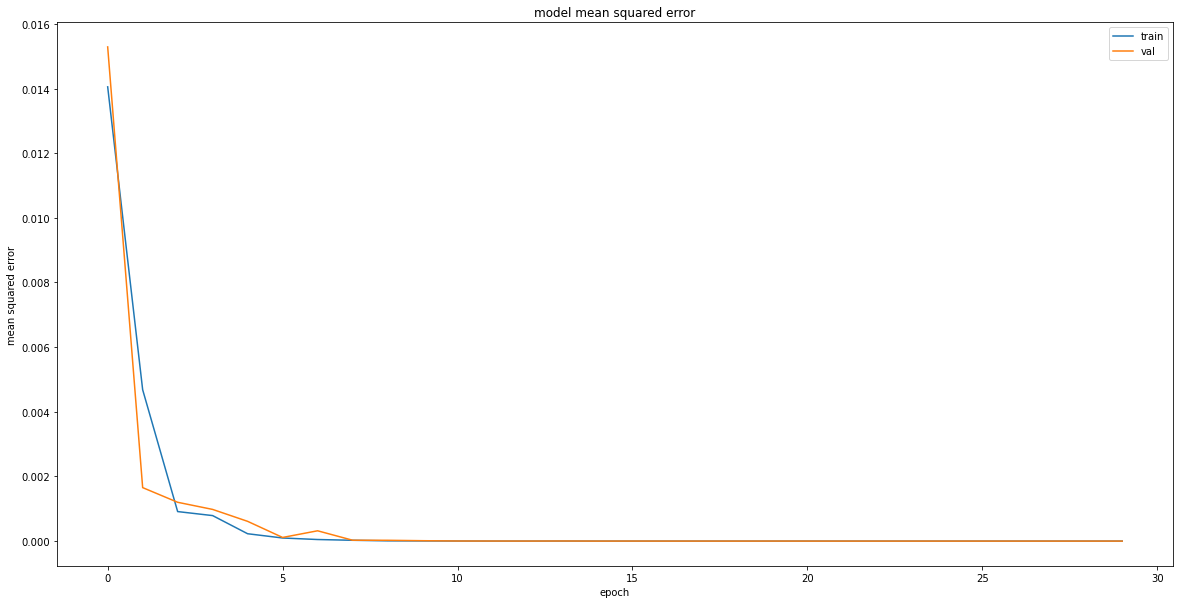

In [32]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mean squared error')
plt.ylabel('mean squared error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

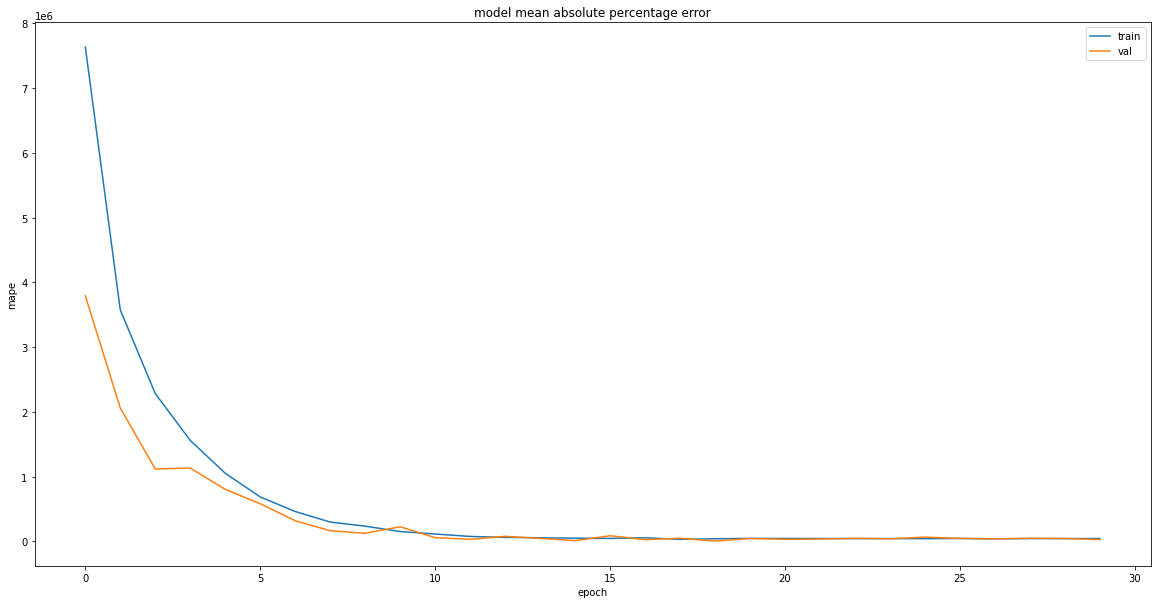

In [33]:
plt.plot(history.history['mape'])
plt.plot(history.history['val_mape'])
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### insights
This model learns quite well 20 epochs in

## Evaluating model on new (unseen data)
should be the %age off of predicting the horizon price

In [34]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_dense_multivariate")
loss = model_6.evaluate(X_test, y_test)

  25/1080 [..............................] - ETA: 4s - loss: 1.9845e-05 - mse: 1.4551e-09 - mape: 2489.1016 - mae: 1.9845e-05 

2022-02-04 18:41:18.710989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1080/1080 [==============================] - 5s 4ms/step - loss: 5.5361e-05 - mse: 7.8190e-07 - mape: 11876.7090 - mae: 5.5361e-05


In [35]:
# percentage
y_pred = model_6.predict(X_test)

2022-02-04 18:41:23.527590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [36]:
type(y_pred)

numpy.ndarray

In [37]:
y_pred

array([[ 1.1509808e-05],
       [ 1.3068377e-05],
       [ 1.6615173e-05],
       ...,
       [-3.2414685e-04],
       [-1.5114143e-05],
       [ 4.7798743e-04]], dtype=float32)

In [38]:
y_test = np.array(y_test)

In [39]:
type(y_test)

numpy.ndarray

In [40]:
y_test

array([ 2.0896456e-07,  0.0000000e+00, -2.0896456e-07, ...,
       -3.6616664e-04,  8.6580030e-07,  3.6530083e-04], dtype=float32)

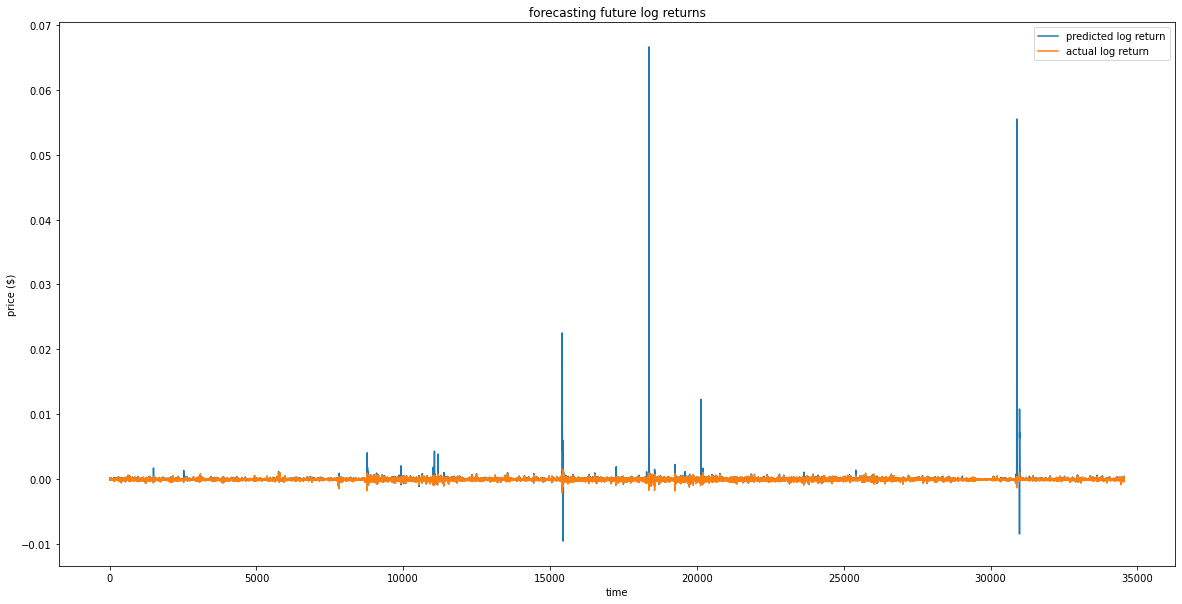

In [41]:
plt.plot(y_pred, label="predicted log return")
plt.plot(y_test, label="actual log return")
plt.title('forecasting future log returns')
plt.ylabel('price ($)')
plt.xlabel('time')
plt.legend(loc='upper right')
plt.show()

## Go from log returns back to price

initial price should be price at X_test.timestamp-1

In [ ]:
p_0 = X_test

In [146]:
# 1 step back as p_initial
p_0_time = X_test.index[0] - pd.Timedelta(X_test.index[0].freq)

In [140]:
p_0_test = df.loc[p_0_time]['Close']

### The price should be initial_price * exp(log_ret.cumsum())

In [148]:
tot_return_pct = y_pred.cumsum()
tot_return_pct

array([1.1509808e-05, 2.4578185e-05, 4.1193358e-05, ..., 1.4350017e+00,
       1.4349866e+00, 1.4354646e+00], dtype=float32)

In [144]:
y_pred_prices = p_0_test*np.exp(y_pred.cumsum())

In [157]:
y_actual_prices = p_0_test*np.exp(y_test.cumsum())

In [158]:
len(y_pred_prices), len(y_actual_prices)

(34554, 34554)

In [155]:
y_pred_prices[:500]

array([47855.555, 47856.176, 47856.973, 47857.8  , 47868.21 , 47868.03 ,
       47878.133, 47878.293, 47881.773, 47881.934, 47882.094, 47876.883,
       47877.043, 47877.203, 47877.363, 47877.523, 47883.227, 47878.79 ,
       47878.95 , 47877.51 , 47877.67 , 47877.832, 47877.99 , 47878.15 ,
       47878.31 , 47878.47 , 47878.63 , 47878.79 , 47878.95 , 47879.11 ,
       47879.27 , 47879.43 , 47879.586, 47879.746, 47879.906, 47880.066,
       47880.227, 47880.387, 47880.547, 47880.707, 47880.867, 47881.023,
       47881.184, 47881.344, 47887.56 , 47887.72 , 47887.875, 47898.836,
       47903.914, 47904.074, 47904.23 , 47904.39 , 47904.55 , 47904.71 ,
       47904.87 , 47909.613, 47912.293, 47915.066, 47915.227, 47917.844,
       47918.004, 47915.637, 47915.797, 47915.957, 47908.96 , 47909.12 ,
       47910.406, 47910.562, 47910.723, 47910.883, 47915.9  , 47922.45 ,
       47927.074, 47927.234, 47931.09 , 47937.082, 47940.652, 47935.324,
       47935.484, 47935.64 , 47935.8  , 47935.96 , 

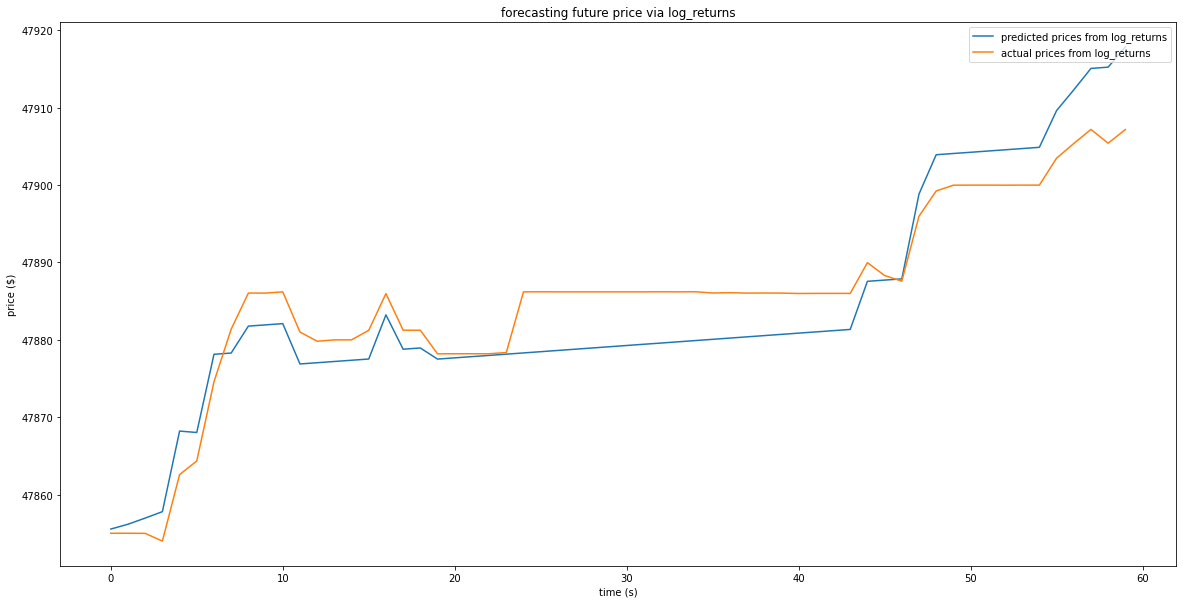

In [162]:
plt.plot(y_pred_prices[:60], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:60], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

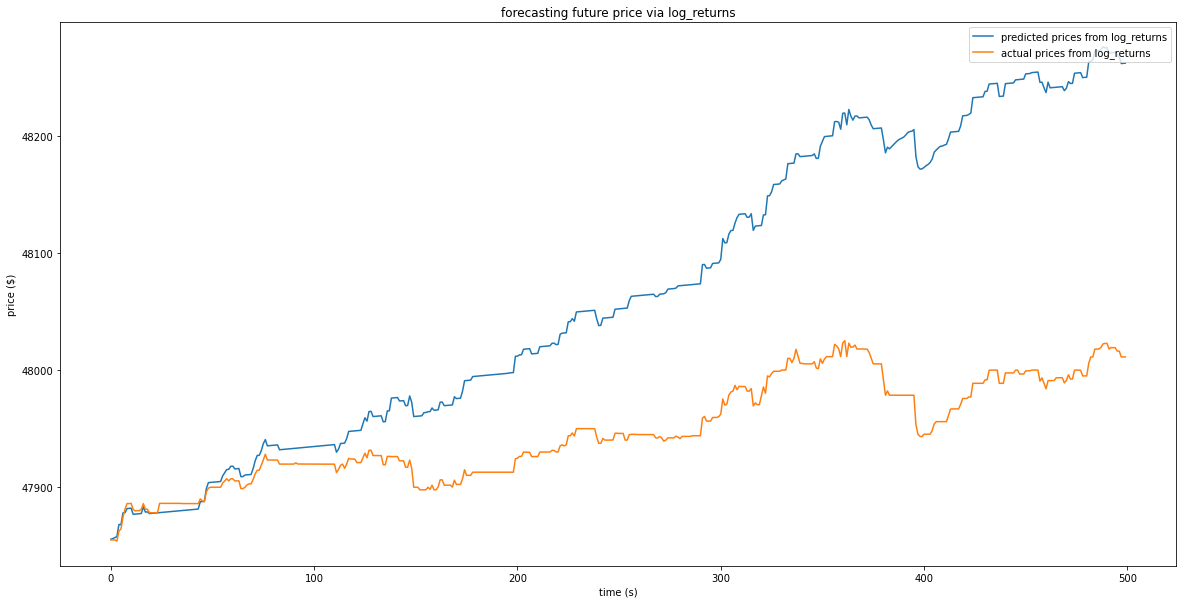

In [160]:
plt.plot(y_pred_prices[:500], label="predicted prices from log_returns")
plt.plot(y_actual_prices[:500], label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()

### Observation: is okay for the first bit of data beyond train/val set, approx 50seconds, afterwards it flies!

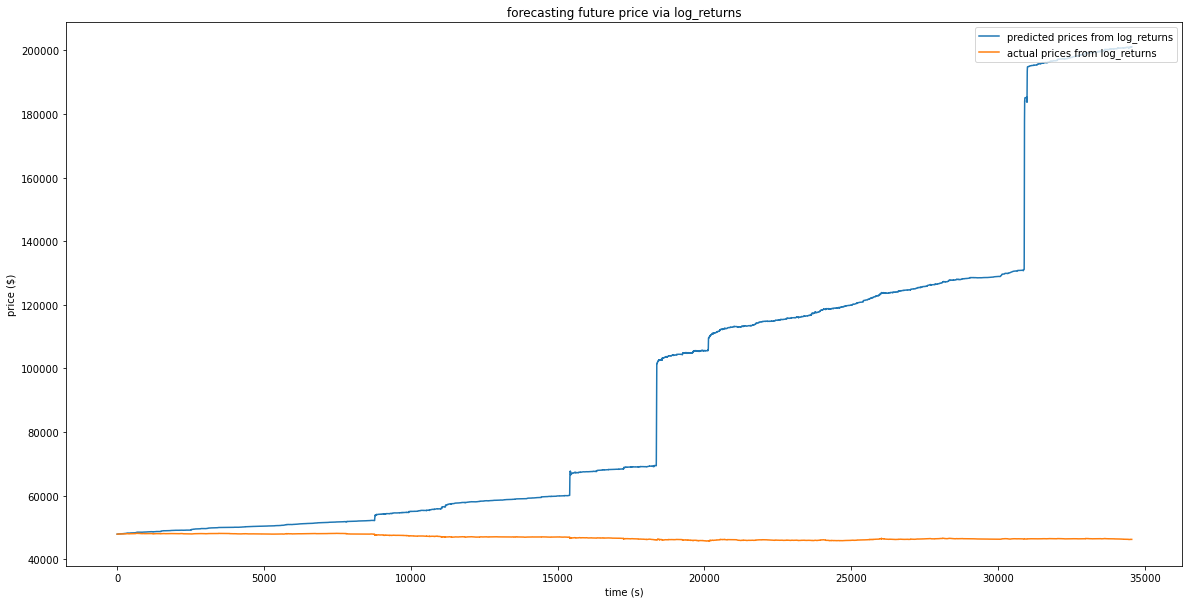

In [161]:
# for example, on the whole testing set
plt.plot(y_pred_prices, label="predicted prices from log_returns")
plt.plot(y_actual_prices, label="actual prices from log_returns")
plt.title('forecasting future price via log_returns')
plt.ylabel('price ($)')
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.show()